# SRCNN - Data augmentation
This notebook implements the super-resolution convolutional neural network, SRCNN, as described by [Dong *et al.*](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13), but expands on the methodology by investigating further data augmentation including:
 * rotation
 * colour channel swapping

This notebook only covers 2 scaling factors: $2\times$ and $4\times$. Results for each can be acquired by changing the scaling factor and re-running the notebook. See the **SRCNN - Baseline model** notebook for further information on the basic model and general methodology.

## Summary
Results from this notebook are summarized. Using $32 \times 32$ training patches ($33 \times 33$ for scaling factor 3), image patch stride of 14, training batch size of 64 and 500 epochs, training took roughly 5 minutes on a GTX 1080 Ti.

| Scaling factor | Image Set | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2\times$ | Set5 |$25.81$ dB | $26.84$ dB | $+1.02$ dB | $0.76$ | $0.79$ | $+0.03$ |
| $2\times$ | Set14 | $23.54$ dB | $24.33$ dB | $+0.79$ dB | $0.65$ | $0.69$ | $+0.04$ |


In [1]:
# Imports.
import numpy as np
from PIL import Image

import site
site.addsitedir('../')
from srcnn_tf2.data.preprocessing import create_xy_patches, import_from_file, scale_batch, center_crop
from srcnn_tf2.data.plotting import n_compare
from srcnn_tf2.model.srcnn_model import SRCNN

# Data locations.
training_folder = '../../../sr_data/T91'
set5_eval_folder = '../../../sr_data/Set5'
set14_eval_folder = '../../../sr_data/Set14'

---
## Data augmentation: Rotation, channel swap, and alternative patching sizes
### Model defintion
Define the model first. Data must be imported on the fly as there are too many options to store the full training data set in memory at the same time (potentially).

In [2]:
srcnn_model = SRCNN(
    num_channels=3,
    f1=9,
    f3=5,
    n1=64,
    n2=32,
    nlin_layers=1,
    activation='relu',
    optimizer='adam',
    loss='mse',
    metrics=['accuracy'],
    padding='valid',
    batch_norm=False
)

srcnn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
None


### Import, preprocess, and train
High-resolution target images, $I_y$, are 32 x 32 pixel sub-images extracted from the original T91 image set. This is done by passing a 32 x 32 pixel window over the originals at a stride of 14 pixels. Target images are then given a Gaussian blur and downscaled by the scaling factor to produce the low-resolution input images, $I_x$. Pre-upscaling for the model is performed as part of the model class. 

#### Patching
Three sizes of patches, all at a stride of 14 will be attemped: $32 \times 32$, $48 \times 48$, $64 \times 64$

#### Rotation

#### Colour channel swapping

In [3]:
# Data options.
# Note: 'scaling_factor' should evenly divide into 'y_image_size'.
y_sizes = [(32, 32), (48, 48), (64, 64)]  # Target image size, patches extracted from T91 inputs.
rotations = [0, 90, 180, 270]
channel_combos = [(0,1,2), (1,2,0), (2,0,1)]
scaling_factor = 2
patch_stride = 14
blur_kernel = -1  # Negative applies blur before downscaling, positive applies blur after downscaling
epochs_per_loop = 2
batch_size = 128

# Run training
for y_image_size in y_sizes:
    for rots in rotations:
        for channels in channel_combos:
            # Data extraction
            # ---------------
            xdata, ydata = create_xy_patches(training_folder,
                                             scaling_factor,
                                             patch_size=y_image_size,
                                             patch_stride=patch_stride,
                                             blur_kernel=blur_kernel,
                                             rotations=[rots], swap_channels=channels)
            print(f"Rotation: {rots} | Image size: {y_image_size} | Channel order: {channels}")
            print(f"Target data size (number of images x image shape x channels): {ydata.shape}")
            print(f"Training data input size (number of images x image shape x channels): {xdata.shape}")
            
            # Model training
            # --------------
            srcnn_model.fit(xdata=xdata, ydata=ydata, epochs=epochs_per_loop, batch_size=batch_size, validation_split=0.1, verbose=1)
            
            del xdata
            del ydata

#srcnn_model.plot_training(figsize=(16, 8), plot_vars=['loss', 'val_loss'])

Rotation: 0 | Image size: (64, 64) | Channel order: (0, 1, 2)
Target data size (number of images x image shape x channels): (16874, 64, 64, 3)
Training data input size (number of images x image shape x channels): (16874, 32, 32, 3)
Epoch 1/2
119/119 [==============================] - 2s 18ms/step - loss: 0.0697 - accuracy: 0.7859 - val_loss: 0.0474 - val_accuracy: 0.9333
Epoch 2/2
119/119 [==============================] - 2s 16ms/step - loss: 0.0186 - accuracy: 0.8764 - val_loss: 0.0046 - val_accuracy: 0.9386
2 epochs completed in 0.0 minutes 7.86 seconds, approx. 3.93 seconds per epoch.
Rotation: 0 | Image size: (64, 64) | Channel order: (1, 2, 0)
Target data size (number of images x image shape x channels): (16874, 64, 64, 3)
Training data input size (number of images x image shape x channels): (16874, 32, 32, 3)
Epoch 1/2
119/119 [==============================] - 2s 16ms/step - loss: 0.0028 - accuracy: 0.9270 - val_loss: 0.0038 - val_accuracy: 0.9343
Epoch 2/2
119/119 [===========

### Evaluate model
We evaluate the model using the images in Set5 and Set14. These are combined and run through our benchmarking method that measures both PSNR and SSIM.

In [4]:
testing_images_5 = import_from_file(set5_eval_folder)
testing_images_14 = import_from_file(set14_eval_folder)

psnr_5, psnr_bicubic_5 = srcnn_model.benchmark(testing_images_5, metric='psnr', return_metrics=True)
psnr_14, psnr_bicubic_14 = srcnn_model.benchmark(testing_images_14, metric='psnr', return_metrics=True)
ssim_5, ssim_bicubic_5 = srcnn_model.benchmark(testing_images_5, metric='ssim', return_metrics=True)
ssim_14, ssim_bicubic_14 = srcnn_model.benchmark(testing_images_14, metric='ssim', return_metrics=True)

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 30.2
		5.2. PSNR: 27.3
		5.3. PSNR: 20.2
		5.4. PSNR: 25.3
		5.5. PSNR: 28.8
	Average PSNR: 26.359

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.2
		5.2. PSNR: 23.2
		5.3. PSNR: 27.4
		5.4. PSNR: 20.4
		5.5. PSNR: 23.6
		5.6. PSNR: 24.6
		5.7. PSNR: 28.2
		5.8. PSNR: 23.5
		5.9. PSNR: 28.8
		5.10. PSNR: 21.6
		5.11. PSNR: 23.2
		5.12. PSNR: 24.3
		5.13. PSNR:

#### PSNR

In [5]:
#srcnn_model.benchmark(testing_images_5, metric='psnr', return_metrics=False)
#srcnn_model.benchmark(testing_images_14, metric='psnr', return_metrics=False)

#### SSIM

In [6]:
#srcnn_model.benchmark(testing_images_5, metric='ssim', return_metrics=False)
#srcnn_model.benchmark(testing_images_14, metric='ssim', return_metrics=False)

In [7]:
print(f"| Scaling factor | Image Set | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |")
print(f"| :------------- | :-------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |")
print(f"| ${scaling_factor}x$ | Set5 |${np.mean(psnr_bicubic_5):.2f}$ dB | ${np.mean(psnr_5):.2f}$ dB | $+{np.mean(psnr_5) - np.mean(psnr_bicubic_5):.2f}$ dB |", end='')
print(f" ${np.mean(ssim_bicubic_5):.2f}$ | ${np.mean(ssim_5):.2f}$ | $+{np.mean(ssim_5) - np.mean(ssim_bicubic_5):.2f}$ |")
print(f"| ${scaling_factor}x$ | Set14 | ${np.mean(psnr_bicubic_14):.2f}$ dB | ${np.mean(psnr_14):.2f}$ dB | $+{np.mean(psnr_14) - np.mean(psnr_bicubic_14):.2f}$ dB |", end='')
print(f" ${np.mean(ssim_bicubic_14):.2f}$ | ${np.mean(ssim_14):.2f}$ | $+{np.mean(ssim_14) - np.mean(ssim_bicubic_14):.2f}$ |")

| Scaling factor | Image Set | Bicubic - PSNR (mean) | SRCNN - PSNR (mean) | PSNR Mean Improvement | Bicubic - SSIM (mean) | SRCNN - SSIM (mean) | SSIM Mean Improvement |
| :------------- | :-------: | :-------------------: | :-----------------: | :-------------------: | :-------------------: | :-----------------: | :-------------------: |
| $2x$ | Set5 |$25.81$ dB | $26.36$ dB | $+0.55$ dB | $0.76$ | $0.78$ | $+0.02$ |
| $2x$ | Set14 | $23.54$ dB | $24.08$ dB | $+0.54$ dB | $0.65$ | $0.68$ | $+0.03$ |


---
### CIFAR-10 Examples
We use the CIFAR-10 dataset as a "real world" application where there is no target with which to compare. We upscale using both the trained SRCNN and bicubic interpolation, and compare visually (there is no metric in this case).

Images are saved with tags so they can be included in the summary and compare across the three scaling factors.

In [8]:
from tensorflow.keras.datasets.cifar10 import load_data

# Data import and definition.
d_example_index = {'airplane': 30,
                   'automobile': 32,
                   'bird': 90,
                   'cat': 91,
                   'deer': 130,
                   'dog': 156,
                   'frog': 72,
                   'horse': 152,
                   'ship': 62,
                   'truck': 122}

(x_train, y_train), (x_test, y_test) = load_data()
del x_test
del y_test
del y_train

label_list, im_list = [], []
for di in d_example_index.keys():
    label_list.append(di)
    im_list.append(x_train[d_example_index[di]])

im_list = np.array(im_list) / 255.0

del x_train
# Save image string.
im_prefix = f'srcnn_rotation_{scaling_factor}x_'

In [9]:
im_pred = srcnn_model.predict(im_list)
im_scale = center_crop(
    images=scale_batch(im_list, (im_list.shape[2]*scaling_factor, im_list.shape[1]*scaling_factor)),
    remove_edge=(im_list.shape[1]*scaling_factor - im_pred.shape[1])//2)

print((im_list.shape[1]*scaling_factor - im_pred.shape[1])//2, im_list.shape[1]*scaling_factor, im_pred.shape[1])

6 64 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


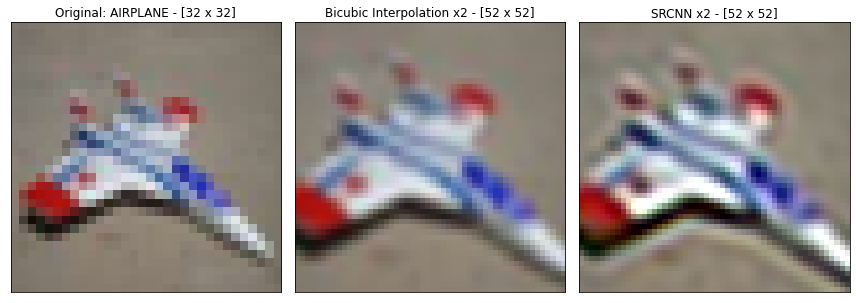

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


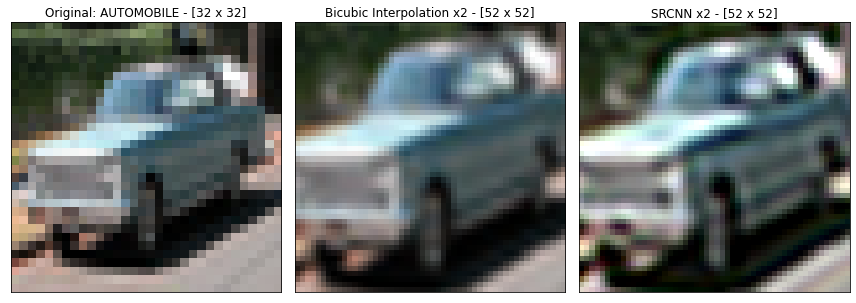

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


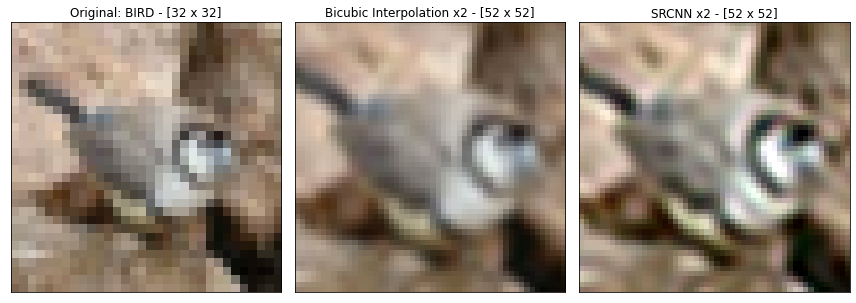

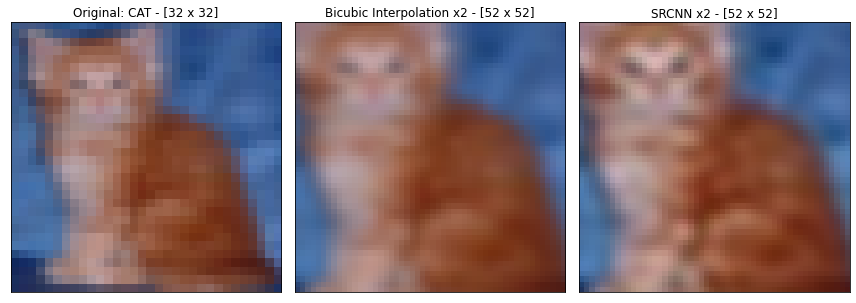

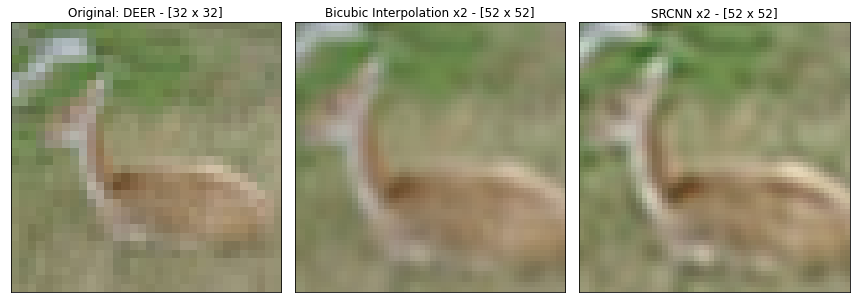

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


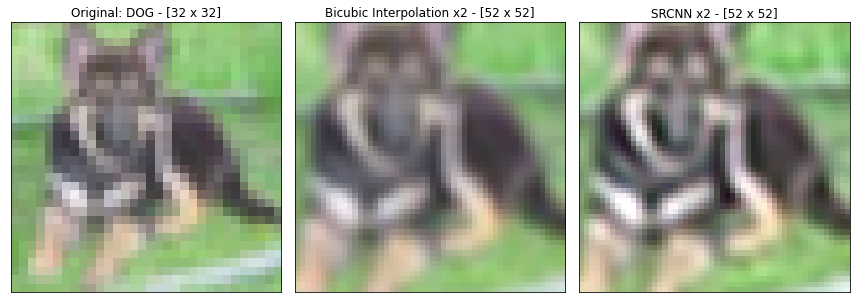

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


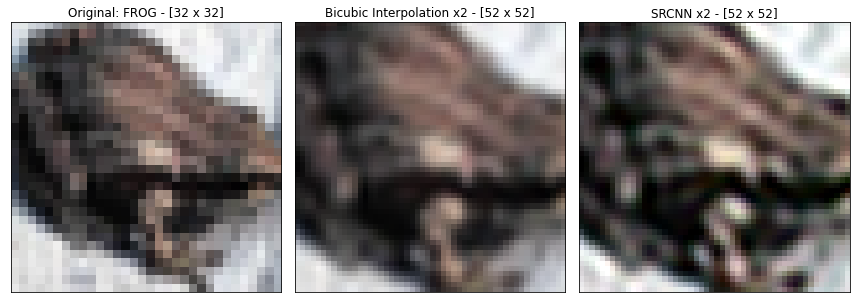

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


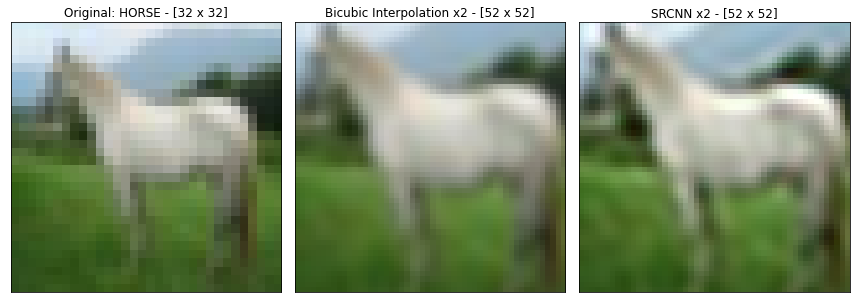

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


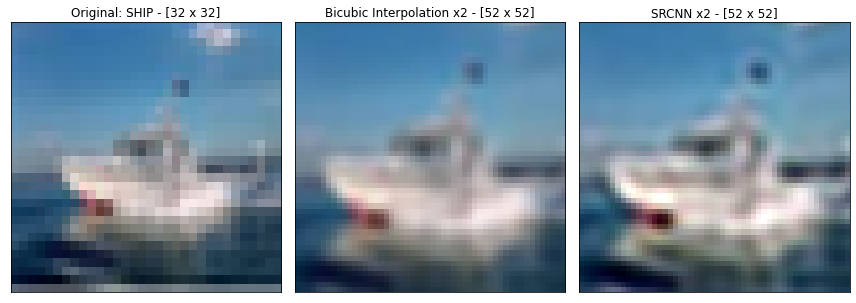

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


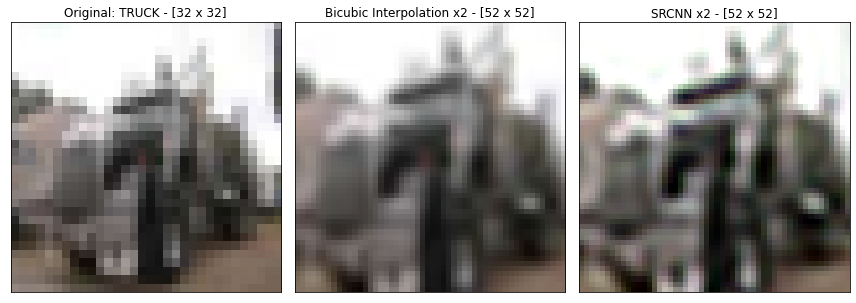

In [10]:
for label, image_raw, image_pred, image_scale in zip(label_list, list(im_list), list(im_pred), list(im_scale)):
    n_compare(
        im_list=[image_raw, image_scale, image_pred],
        label_list=[f'Original: {label.upper()} - [{image_raw.shape[1]} x {image_raw.shape[0]}]',
                    f'Bicubic Interpolation x{scaling_factor} - [{image_scale.shape[1]} x {image_scale.shape[0]}]',
                    f'SRCNN x{scaling_factor} - [{image_pred.shape[1]} x {image_pred.shape[0]}]'],
        figsize=(12,5))
    
    #im = Image.fromarray(np.uint8(image_pred*255))
    #im.save(f"results/{im_prefix}{label}.png")